## Task 4 - Stock Market Prediction using Numerical and Textual Analysis

### Author: Renaldy Dwi Nugraha

### Task: 

- Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines
- Stock to analyze and predict SENSEX (S&P BSE SENSEX)
- Download historical stock prices from https://www.finance.yahoo.com
- Download textual (news) data from https://bit.ly/36fFPI6
- Use either R or Python, or both for separate analysis and then combine the findings to create a hybrid model

In [1]:
#import all the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import keras
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adagrad
from sklearn.preprocessing import MinMaxScaler

import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

from nltk.corpus import names as names_ntlk
import nltk
import statistics
import scipy
from IPython.display import display
import networkx as nx
from networkx.algorithms import bipartite

import csv
import time 
import requests
from bs4 import BeautifulSoup
import re
from urllib.request import urlopen
from sklearn.preprocessing.data import QuantileTransformer
%matplotlib inline


Using TensorFlow backend.
C:\Users\renal\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 6, 30)

df = web.DataReader("^BSESN", 'yahoo', start, end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,17582.839844,17378.380859,17473.449219,17558.730469,28200.0,17558.730469
2010-01-05,17729.779297,17555.769531,17555.769531,17686.240234,27000.0,17686.240234
2010-01-06,17790.330078,17636.710938,17719.470703,17701.130859,21400.0,17701.130859
2010-01-07,17733.339844,17566.539062,17701.970703,17615.720703,18000.0,17615.720703
2010-01-08,17658.119141,17508.960938,17603.869141,17540.289062,17200.0,17540.289062
...,...,...,...,...,...,...
2020-06-24,35706.550781,34794.929688,35679.738281,34868.980469,26600.0,34868.980469
2020-06-25,35081.609375,34499.781250,34525.390625,34842.101562,24600.0,34842.101562
2020-06-26,35254.878906,34910.339844,35144.781250,35171.269531,24800.0,35171.269531


In [3]:
df.isna().any()

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

In [4]:
df['Change'] = round(df['Close'] - df['Open'], 2)
df

,High,Low,Open,Close,Volume,Adj Close,Change
Date,,,,,,,
2010-01-04,17582.839844,17378.380859,17473.449219,17558.730469,28200.0,17558.730469,85.28
2010-01-05,17729.779297,17555.769531,17555.769531,17686.240234,27000.0,17686.240234,130.47
2010-01-06,17790.330078,17636.710938,17719.470703,17701.130859,21400.0,17701.130859,-18.34
2010-01-07,17733.339844,17566.539062,17701.970703,17615.720703,18000.0,17615.720703,-86.25
2010-01-08,17658.119141,17508.960938,17603.869141,17540.289062,17200.0,17540.289062,-63.58
...,...,...,...,...,...,...,...
2020-06-24,35706.550781,34794.929688,35679.738281,34868.980469,26600.0,34868.980469,-810.76
2020-06-25,35081.609375,34499.781250,34525.390625,34842.101562,24600.0,34842.101562,316.71
2020-06-26,35254.878906,34910.339844,35144.781250,35171.269531,24800.0,35171.269531,26.49


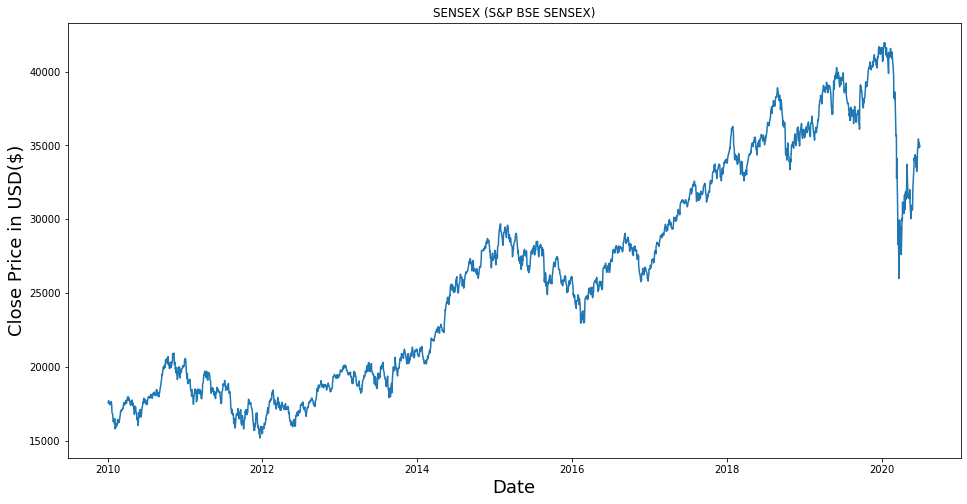

In [5]:
# Visualize the close price history
plt.figure(figsize=(16,8))
plt.title('SENSEX (S&P BSE SENSEX)')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price in USD($)', fontsize = 18)
plt.plot(df['Close'])
plt.show()

In [6]:

# Get th close price
data=df.filter(['Close'])
dataset = data.values

training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

2060

In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data

array([[0.08901675],
       [0.09377857],
       [0.09433465],
       ...,
       [0.74675205],
       [0.73891899],
       [0.73721164]])

In [8]:
#Create the training data set
train_data = scaled_data[0:training_data_len, :]
#Split the data int x and y train
x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
    

[array([0.08901675, 0.09377857, 0.09433465, 0.09114503, 0.08832806,
       0.08782099, 0.08392963, 0.08718949, 0.08999289, 0.08885133,
       0.09209207, 0.08630291, 0.08587082, 0.07006095, 0.0629109 ,
       0.05995249, 0.04162966, 0.04226638, 0.04417432, 0.04410225,
       0.03691004, 0.04933128, 0.0392071 , 0.02299873, 0.02840179,
       0.03238159, 0.02789986, 0.03650483, 0.03223856, 0.03927169,
       0.04682393, 0.04304949, 0.03796277, 0.03965896, 0.04149895,
       0.04036552, 0.04029944, 0.04684785, 0.05965746, 0.06815148,
       0.06709423, 0.06794536, 0.07198267, 0.07011318, 0.07182323,
       0.07442357, 0.07437346, 0.07431263, 0.08246086, 0.08645302,
       0.08754273, 0.08974497, 0.08348375, 0.08499432, 0.0890212 ,
       0.09222949, 0.09471627, 0.09019085, 0.08786052, 0.09401679])]
[0.10309381292119935]


In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data (since LSTM use 3dimension)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2000, 60, 1)

## Stock Prediction by using  Long-Short Term Memory

In [10]:
model = Sequential()
model.add(tf.keras.layers.LSTM(units=256, return_sequences=True,
                  input_shape = (x_train.shape[1],1)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units=256, return_sequences=False))

model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 815,305
Trainable params: 815,305
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Compile the mode
history=model.fit(x_train, y_train, batch_size=10, epochs=50)

Epoch 1/50
200/200 [==============================] - 5s 23ms/step - loss: 0.0104
Epoch 2/50
200/200 [==============================] - 5s 23ms/step - loss: 0.0017
Epoch 3/50
200/200 [==============================] - 4s 22ms/step - loss: 0.0013
Epoch 4/50
200/200 [==============================] - 5s 23ms/step - loss: 0.0010
Epoch 5/50
200/200 [==============================] - 4s 22ms/step - loss: 8.9628e-04
Epoch 6/50
200/200 [==============================] - 5s 23ms/step - loss: 7.4829e-04
Epoch 7/50
200/200 [==============================] - 5s 23ms/step - loss: 6.7125e-04
Epoch 8/50
200/200 [==============================] - 5s 23ms/step - loss: 6.0170e-04
Epoch 9/50
200/200 [==============================] - 4s 22ms/step - loss: 5.7305e-04
Epoch 10/50
200/200 [==============================] - 4s 22ms/step - loss: 5.0666e-04
Epoch 11/50
200/200 [==============================] - 5s 23ms/step - loss: 4.8480e-04
Epoch 12/50
200/200 [==============================] - 4s 22ms/step 

In [12]:
test_data = scaled_data[training_data_len - 60:, :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
#convert data to numpy array
x_test=np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
#Predicted the model values
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

In [15]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

310.5080442910992

C:\Users\renal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


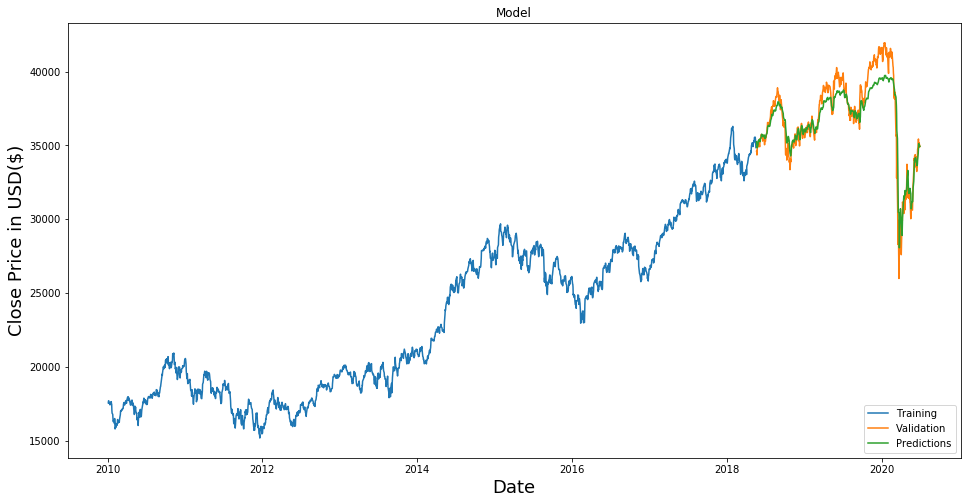

In [16]:
#Plot 
train= data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='lower right')
plt.show()

The lstm model performed a good prediction result with only 100 second run time(by using tensorflow-gpu )

In [17]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-21,34616.128906,35244.890625
2018-05-22,34651.238281,35047.773438
2018-05-23,34344.910156,34947.707031
2018-05-24,34663.109375,34832.179688
2018-05-25,34924.871094,34875.011719
...,...,...
2020-06-24,34868.980469,35118.308594
2020-06-25,34842.101562,35109.375000
2020-06-26,35171.269531,34981.847656


In [18]:
#Check the stock at June 2020
stock_quote = web.DataReader("^BSESN", 'yahoo', start='2020-01-01', end='2020-06-30')
checked_stock = stock_quote.filter(['Close'])

#Get the last 60days of Close price and convert to dataframe
last_60_days=checked_stock[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)

X_test=np.array(X_test)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price=model.predict(X_test)
pred_price=scaler.inverse_transform(pred_price)
print(pred_price)

#Get the quote
stock_quote2 = web.DataReader("^BSESN", 'yahoo', start='2020-06-30', end='2020-06-30')
print(stock_quote2['Close'])



[[34907.992]]
Date
2020-06-30    34915.800781
Name: Close, dtype: float64


## News headlines and Numerical Analysis.

In [19]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Global Parameters
#stop_words = set(stopwords.words('english'))

In [20]:
#Use NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\renal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
news = pd.read_csv('india-news-headlines.csv')
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


In [22]:
news.head(5)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [23]:
news.tail(5)

,publish_date,headline_category,headline_text
3297167,20200630,gadgets-news,why tiktok removed 1 65 crore videos in india
3297168,20200630,entertainment.hindi.bollywood,apurva asrani calls alia bhatts mother soni ra...
3297169,20200630,entertainment.hindi.bollywood,kangana ranaut gets a doll version of herself ...
3297170,20200630,entertainment.hindi.bollywood,meezaan jaffrey reminisces his childhood days ...
3297171,20200630,entertainment.telugu.movies.news,prabhas20 titled as radhe shyam prabhas and po...


In [24]:
print('There are', news.headline_category.nunique(), 'unique words')

There are 1016 unique words


In [25]:
news.isna().any()

publish_date         False
headline_category    False
headline_text        False
dtype: bool

In [26]:
news.headline_category.value_counts()

india                      285619
unknown                    207732
city.mumbai                132649
city.delhi                 124658
business.india-business    115246
                            ...  
delhi-ncr                       7
sports.headline3                7
did-you-know                    6
sports.headline6                3
party-manifestos                2
Name: headline_category, Length: 1016, dtype: int64

In [27]:
news.headline_text.value_counts()

Sunny Leone HOT photos                                       98
Watch top news in one-minute                                 90
Official Site                                                89
Football: Italian Serie A table                              88
Football: Spanish La Liga table                              86
                                                             ..
Stephen's to pay homage to Kamte                              1
Most hazardous to health; ultra-fine particles under lens     1
For UP team; 1 cycle for 21 participants                      1
Esha Gupta: I don't give credit to anyone for my career       1
Shed inhibitions to join 'em                                  1
Name: headline_text, Length: 3082589, dtype: int64

In [28]:
#Load news from local file 
news['publish_date']= pd.to_datetime(news['publish_date'], format='%Y%m%d').dt.date
#or you can use pd.to_datetime(news.publish_date, format='%Y-%m-%d')

#Sort by Date
news_time = news.sort_values('publish_date')

news_time

,publish_date,headline_category,headline_text
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...
64,2001-01-02,unknown,Petition over ministers' assets dismissed
63,2001-01-02,unknown,Bomb hoax triggers panic in Canara Bank
62,2001-01-02,unknown,Consul is back from month-long leave
61,2001-01-02,unknown,Redemption night; amid some rock
...,...,...,...
3296806,2020-06-30,city.mangaluru,Mangaluru police jittery as arrested accused t...
3296805,2020-06-30,city.chennai,Madras university gets a patent for finding an...
3296804,2020-06-30,city.visakhapatnam,Andhra Pradesh: Rise in caseload; Covid care c...
3296818,2020-06-30,city.ranchi,Woman hangs self a day after son's suicide


### Data cleaning (Remove punctuation)

Remove the punctuation such as : '!@#$%^&*():"<>,.;'[]\\|?{}~`' etc

In [29]:
import string 
string.punctuation

def remove_punc(message):
    Test_punc_removed = [   char   for char in message if char not in string.punctuation    ]
    Test_punc_removed_join = ''.join(Test_punc_removed) #join together with no space in between
    return Test_punc_removed_join

In [30]:
news_time['headline_text'] = news_time['headline_text'].apply(remove_punc)
news_time

,publish_date,headline_category,headline_text
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...
64,2001-01-02,unknown,Petition over ministers assets dismissed
63,2001-01-02,unknown,Bomb hoax triggers panic in Canara Bank
62,2001-01-02,unknown,Consul is back from monthlong leave
61,2001-01-02,unknown,Redemption night amid some rock
...,...,...,...
3296806,2020-06-30,city.mangaluru,Mangaluru police jittery as arrested accused t...
3296805,2020-06-30,city.chennai,Madras university gets a patent for finding an...
3296804,2020-06-30,city.visakhapatnam,Andhra Pradesh Rise in caseload Covid care cen...
3296818,2020-06-30,city.ranchi,Woman hangs self a day after sons suicide


### Data cleaning (Remove Stopwords)

In [31]:
#Example of Stopwords
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\renal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [32]:
#optained stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['https', 'http', 'from','re','edu', 'will','co','day', 'user','stock', 'you','today', 'week', 'year','subject', 're'])

In [33]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# Remove stopwords and short words (less than 2 character)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words and len(token) >=3:
            result.append(token)
    return result

#Apply pre-processing to the text column
news_time['headline_text']=news_time['headline_text'].apply(preprocess)

In [34]:
news_time

,publish_date,headline_category,headline_text
0,2001-01-01,sports.wwe,"[win, cena, satisfying, defeating, undertaker,..."
64,2001-01-02,unknown,"[petition, ministers, assets, dismissed]"
63,2001-01-02,unknown,"[bomb, hoax, triggers, panic, canara, bank]"
62,2001-01-02,unknown,"[consul, back, monthlong, leave]"
61,2001-01-02,unknown,"[redemption, night, amid, rock]"
...,...,...,...
3296806,2020-06-30,city.mangaluru,"[mangaluru, police, jittery, arrested, accused..."
3296805,2020-06-30,city.chennai,"[madras, university, gets, patent, finding, an..."
3296804,2020-06-30,city.visakhapatnam,"[andhra, pradesh, rise, caseload, covid, care,..."
3296818,2020-06-30,city.ranchi,"[woman, hangs, self, sons, suicide]"


In [35]:
#Take the text, join it and add space in between to create a new outcome stored in  'headline_text'
news_time['headline_text']= news_time['headline_text'].apply(lambda x:" ".join(x)) 
news_time

,publish_date,headline_category,headline_text
0,2001-01-01,sports.wwe,win cena satisfying defeating undertaker bigge...
64,2001-01-02,unknown,petition ministers assets dismissed
63,2001-01-02,unknown,bomb hoax triggers panic canara bank
62,2001-01-02,unknown,consul back monthlong leave
61,2001-01-02,unknown,redemption night amid rock
...,...,...,...
3296806,2020-06-30,city.mangaluru,mangaluru police jittery arrested accused test...
3296805,2020-06-30,city.chennai,madras university gets patent finding anticanc...
3296804,2020-06-30,city.visakhapatnam,andhra pradesh rise caseload covid care centre...
3296818,2020-06-30,city.ranchi,woman hangs self sons suicide


In [36]:
# We don't need headline_category variables
news_time.drop(0, inplace=True)
news_time.drop('headline_category', axis = 1, inplace=True)
news_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297171 entries, 64 to 3297171
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   publish_date   object
 1   headline_text  object
dtypes: object(2)
memory usage: 75.5+ MB


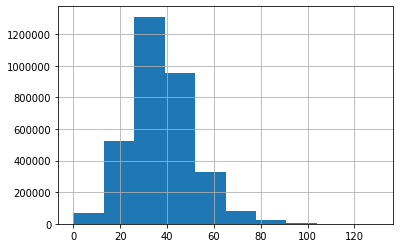

In [37]:
#plot headline before grouping by date
news_time['headline_text'].str.len().hist()
plt.show()

### Group the headlines by date

In [38]:
news_time['headline_text'] = news_time.groupby(['publish_date']).transform(lambda x : ' '.join(x)) 
news_time = news_time.drop_duplicates() 
news_time.reset_index(inplace = True, drop = True)
news_time

,publish_date,headline_text
0,2001-01-02,petition ministers assets dismissed bomb hoax ...
1,2001-01-03,flat tyres flat music famous faces noisy spots...
2,2001-01-04,right choice key says iranian coach rajasthan ...
3,2001-01-05,meeting review antidefection law guala closure...
4,2001-01-06,australia new zealand urged accept indofijian ...
...,...,...
7074,2020-06-26,gehlot posts selfie mask part govts campaign c...
7075,2020-06-27,many traders shutters districts ktr telugu nri...
7076,2020-06-28,riots participants main accused delhi court hi...
7077,2020-06-29,narendra modi must explain chinese donations f...


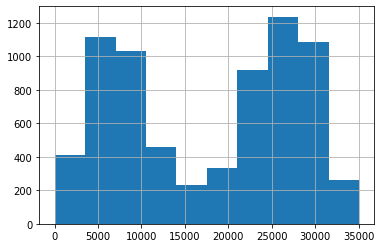

In [39]:
news_time['headline_text'].str.len().hist()
plt.show()

### Subjectivity and Polarity by TextBolb

In [40]:
from textblob import TextBlob
def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

news_time['Polarity'] = news_time['headline_text'].apply(polarity)
news_time['Subjectivity'] = news_time['headline_text'].apply(subjectivity)
news_time

C:\Users\renal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\renal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,publish_date,headline_text,Polarity,Subjectivity
0,2001-01-02,petition ministers assets dismissed bomb hoax ...,0.121014,0.263406
1,2001-01-03,flat tyres flat music famous faces noisy spots...,0.112500,0.433333
2,2001-01-04,right choice key says iranian coach rajasthan ...,0.054074,0.442101
3,2001-01-05,meeting review antidefection law guala closure...,0.266578,0.477807
4,2001-01-06,australia new zealand urged accept indofijian ...,0.248485,0.439394
...,...,...,...,...
7074,2020-06-26,gehlot posts selfie mask part govts campaign c...,0.044779,0.363436
7075,2020-06-27,many traders shutters districts ktr telugu nri...,0.069185,0.382992
7076,2020-06-28,riots participants main accused delhi court hi...,0.041657,0.404719
7077,2020-06-29,narendra modi must explain chinese donations f...,0.045920,0.379911


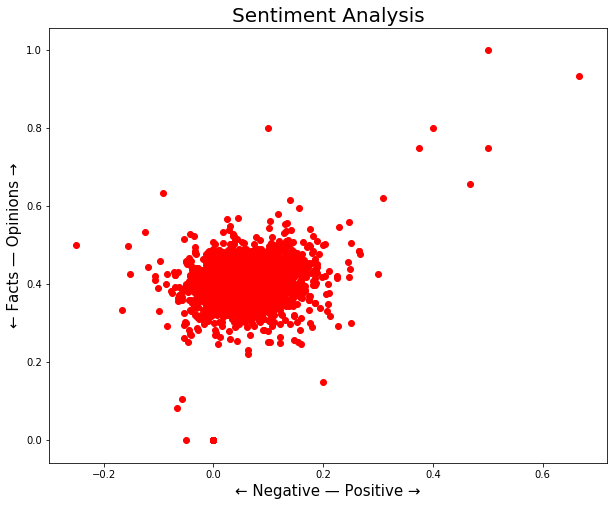

In [41]:
# plot the sentiment after grouping by date
plt.rcParams['figure.figsize'] = [10, 8]
for index, headline_text in enumerate(news_time.index):
    x = news_time.Polarity.loc[headline_text]
    y = news_time.Subjectivity.loc[headline_text]
    plt.scatter(x, y, color='Red')

plt.title('Sentiment Analysis', fontsize = 20)
plt.xlabel('← Negative — Positive →', fontsize=15)
plt.ylabel('← Facts — Opinions →', fontsize=15)
plt.show()

the polarity score ranges from -1 to 1 which depicts the sentiment as negative to positive whereas the subjectivity score ranges from 0 to 1 which depicts the sentiment as objective to subjective. Another method to define the sentiment is by using Vander Sentiment

## Vander Sentiment
reference: https://github.com/cjhutto/vaderSentiment
reference papers: VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text (by C.J. Hutto and Eric Gilbert). Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.


The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

C.J. Hutto and Eric Gilbert were used this specific threshold:
- positive sentiment: compound score >= 0.05
- neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
- negative sentiment: compound score <= -0.05

In [42]:
#In this project i just use compound score
analyzer = SentimentIntensityAnalyzer()
news_time['Compound'] = [analyzer.polarity_scores(v)['compound'] for v in news_time['headline_text']]

# You can check another variables such as negative, neutral and positive by following code:
#news_time['Negative'] = [analyzer.polarity_scores(v)['neg'] for v in news_time['headline_text']]
#news_time['Neutral'] = [analyzer.polarity_scores(v)['neu'] for v in news_time['headline_text']]
#news_time['Positive'] = [analyzer.polarity_scores(v)['pos'] for v in news_time['headline_text']]
news_time

C:\Users\renal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,publish_date,headline_text,Polarity,Subjectivity,Compound
0,2001-01-02,petition ministers assets dismissed bomb hoax ...,0.121014,0.263406,-0.9662
1,2001-01-03,flat tyres flat music famous faces noisy spots...,0.112500,0.433333,0.4019
2,2001-01-04,right choice key says iranian coach rajasthan ...,0.054074,0.442101,0.5423
3,2001-01-05,meeting review antidefection law guala closure...,0.266578,0.477807,0.9869
4,2001-01-06,australia new zealand urged accept indofijian ...,0.248485,0.439394,-0.4215
...,...,...,...,...,...
7074,2020-06-26,gehlot posts selfie mask part govts campaign c...,0.044779,0.363436,-0.9998
7075,2020-06-27,many traders shutters districts ktr telugu nri...,0.069185,0.382992,-0.9998
7076,2020-06-28,riots participants main accused delhi court hi...,0.041657,0.404719,-0.9998
7077,2020-06-29,narendra modi must explain chinese donations f...,0.045920,0.379911,-0.9998


In [43]:
#define the vander sentiment function
def classify_compound(text, threshold=0.05):
     
    # initialize VADER
    analyzer = SentimentIntensityAnalyzer()
     
    # outputs a dictionary with negative, neutral, positive, and compound scores for the input text
    scores = analyzer.polarity_scores(text)
     
    # get compound score
    score = scores['compound']
     
    # translate the score into the correcponding input according to the threshold
    if score <= -threshold: return 'Negative'
    elif score >= threshold: return 'Positive'
    else: return 'Neutral'
     
news_time['Label'] = news_time['headline_text'].apply(classify_compound)


C:\Users\renal\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
news_time['Label'].value_counts()

Negative    6683
Positive     378
Neutral       18
Name: Label, dtype: int64

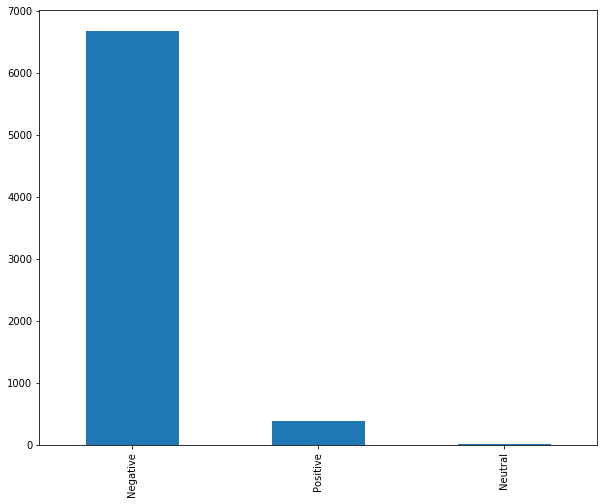

In [45]:
# Plotting
news_time['Label'].value_counts().plot(kind = 'bar')
plt.show()

In [46]:
news_time[news_time['Label']=='Positive'].head()

,publish_date,headline_text,Polarity,Subjectivity,Compound,Label
1,2001-01-03,flat tyres flat music famous faces noisy spots...,0.112500,0.433333,0.4019,Positive
2,2001-01-04,right choice key says iranian coach rajasthan ...,0.054074,0.442101,0.5423,Positive
3,2001-01-05,meeting review antidefection law guala closure...,0.266578,0.477807,0.9869,Positive
10,2001-01-23,pooja batra curry pooja nasir khan small big b...,0.067562,0.269904,0.9186,Positive
14,2001-01-27,govt dispensaries open night caught stick stur...,0.039706,0.376471,0.9429,Positive


In [47]:
news_time[news_time['Label']=='Negative'].head()

,publish_date,headline_text,Polarity,Subjectivity,Compound,Label
0,2001-01-02,petition ministers assets dismissed bomb hoax ...,0.121014,0.263406,-0.9662,Negative
4,2001-01-06,australia new zealand urged accept indofijian ...,0.248485,0.439394,-0.4215,Negative
5,2001-01-07,need farmers become professionals expert resid...,-0.064087,0.365356,-0.9942,Negative
6,2001-01-08,criminals beat family iron rods policemen find...,-0.041519,0.404411,-0.9709,Negative
7,2001-01-09,new molecule fight malaria found construction ...,-0.052749,0.514329,-0.9940,Negative


In [48]:
news_time[news_time['Label']=='Neutral'].head()

,publish_date,headline_text,Polarity,Subjectivity,Compound,Label
9,2001-01-11,japan edge north korea politically charged ope...,0.250000,0.300000,0.0000,Neutral
41,2001-02-24,kannada film bags award lok ayukta probe irreg...,0.074242,0.394697,0.0459,Neutral
47,2001-03-02,long journey,-0.050000,0.400000,0.0000,Neutral
49,2001-03-09,maneka asks govt take back land cow shelter,-0.066667,0.083333,0.0000,Neutral
54,2001-03-16,tape tell,0.000000,0.000000,0.0000,Neutral


In [49]:
#i tried the merge two data in 'publish_date' and 'Date' but it doesn't work well, therefore i change the column 'publish_date' into 'Date', and merge it 
news_time=news_time.rename(columns={'publish_date':'Date'})

In [50]:
sen_news = pd.DataFrame({'Polarity': news_time.groupby(['Date'])['Polarity'].sum()}).reset_index()
stock = pd.DataFrame({'Change': df.groupby(['Date'])['Change'].sum()}).reset_index()
stock

,Date,Change
0,2010-01-04,85.28
1,2010-01-05,130.47
2,2010-01-06,-18.34
3,2010-01-07,-86.25
4,2010-01-08,-63.58
...,...,...
2569,2020-06-24,-810.76
2570,2020-06-25,316.71
2571,2020-06-26,26.49
2572,2020-06-29,34.57


## Merge the sentiment and the stock by Date, change, and polarity

In [51]:
xsen = sen_news.set_index('Date')
xstock= stock.set_index('Date')
xsen

,Polarity
Date,
2001-01-02,0.121014
2001-01-03,0.112500
2001-01-04,0.054074
2001-01-05,0.266578
2001-01-06,0.248485
...,...
2020-06-26,0.044779
2020-06-27,0.069185
2020-06-28,0.041657


In [52]:
xstock

,Change
Date,
2010-01-04,85.28
2010-01-05,130.47
2010-01-06,-18.34
2010-01-07,-86.25
2010-01-08,-63.58
...,...
2020-06-24,-810.76
2020-06-25,316.71
2020-06-26,26.49


In [53]:
startdate = pd.to_datetime('2010-01-04').date()
enddate = pd.to_datetime('2020-06-30').date()
xsen_news=xsen.loc[startdate:enddate]
#xsen_news=xsen[(sen_news['Date'] > '2010-1-3') & (sen_news['Date'] <= '2020-6-30')]
xsen_news

,Polarity
Date,
2010-01-04,0.038905
2010-01-05,-0.011326
2010-01-06,0.037642
2010-01-07,0.009036
2010-01-08,0.000982
...,...
2020-06-26,0.044779
2020-06-27,0.069185
2020-06-28,0.041657


In [54]:
stock.columns

Index(['Date', 'Change'], dtype='object')

In [55]:
sen_news.columns

Index(['Date', 'Polarity'], dtype='object')

In [56]:
AA= df.filter(['Change'])
df_final = pd.concat([xsen, xstock], join = 'outer', axis = 1) 
df_final

,Polarity,Change
Date,,
2001-01-02,0.121014,NaN
2001-01-03,0.112500,NaN
2001-01-04,0.054074,NaN
2001-01-05,0.266578,NaN
2001-01-06,0.248485,NaN
...,...,...
2020-06-26,0.044779,26.49
2020-06-27,0.069185,NaN
2020-06-28,0.041657,NaN


In [57]:
#Remove the NaN
final=df_final.dropna()
final

,Polarity,Change
Date,,
2010-01-04,0.038905,85.28
2010-01-05,-0.011326,130.47
2010-01-06,0.037642,-18.34
2010-01-07,0.009036,-86.25
2010-01-08,0.000982,-63.58
...,...,...
2020-06-24,0.070192,-810.76
2020-06-25,0.002415,316.71
2020-06-26,0.044779,26.49


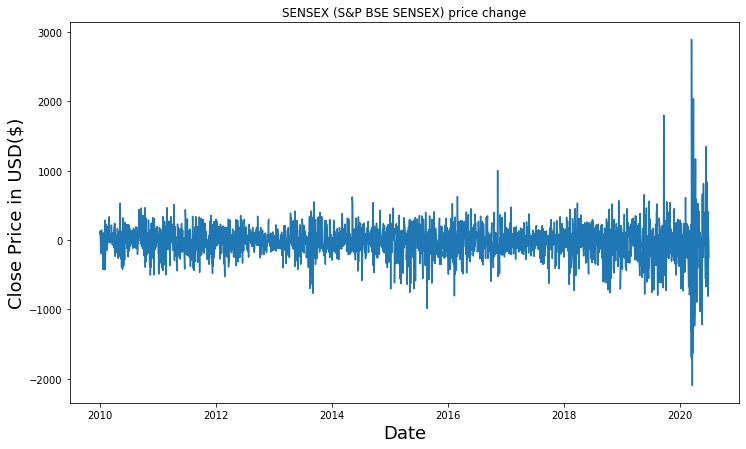

In [58]:

# Visualize the close price history
plt.figure(figsize=(12,7))
plt.title('SENSEX (S&P BSE SENSEX) price change')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price in USD($)', fontsize = 18)
plt.plot(final['Change'])
plt.show()

Since there are no sentiment score datasets, i checked the polarity

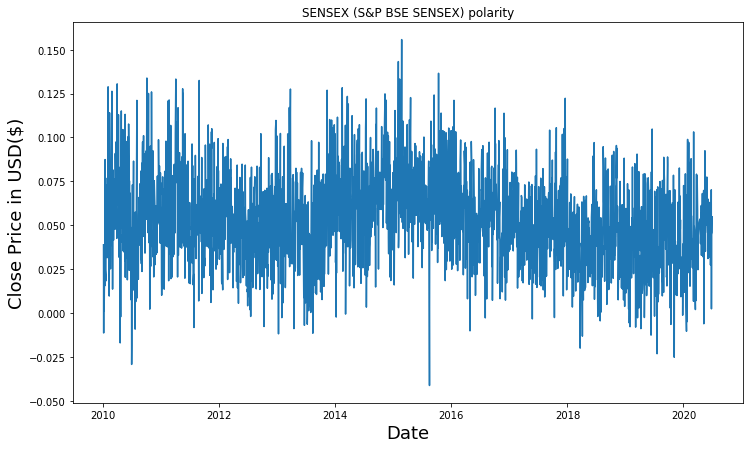

In [59]:

# Visualize the polarity history
plt.figure(figsize=(12,7))
plt.title('SENSEX (S&P BSE SENSEX) polarity')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price in USD($)', fontsize = 18)
plt.plot(final['Polarity'])
plt.show()

Text(0.5, 1.0, 'Price change vs Polarity')

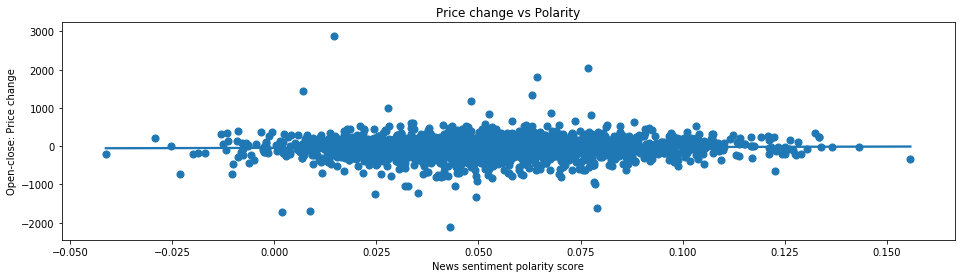

In [60]:
plt.figure(figsize=(16,4))
ax=sns.regplot(x='Polarity', y='Change', data=final, x_estimator=np.mean)
plt.xlabel('News sentiment polarity score')
plt.ylabel('Open-close: Price change')
plt.title('Price change vs Polarity')